# Data Windowing and Creating Baselines for Deep Learning

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.grid'] = False

In [4]:
print(tf.__version__)

2.13.1


In [5]:
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
train_df = pd.read_csv('data/train.csv', index_col=0)
val_df = pd.read_csv('data/val.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


## Creating Windows of Data

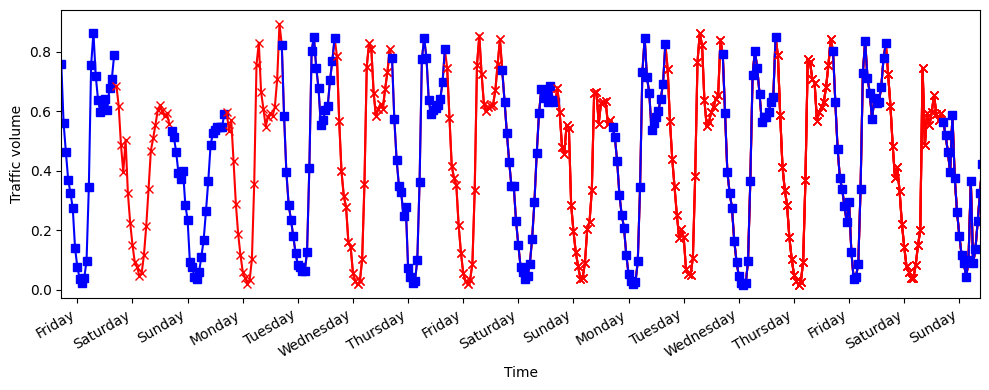

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))

for n in range(0,17,2):
    start = 24*n
    stop = 24*(n+1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', color='red', label='label')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 
                                   'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 
                                   'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

*Visualizing the data windows on the training set. The inputs are shown with square
markers, and the labels are shown with crosses. Each data window consists of 24 timesteps with
square markers followed by 24 labels with crosses.*

#### Implementing the DataWindow class

In [11]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns    # Name of the column that we wish to predict
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)} # Create a dict. with the name and index of the label column
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}         # Create a dict. with the name and index of each column
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)   # The slice function returns a slice object that specifies how to slice a sequence
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]  # Assign indices to the inputs
        
        self.label_start = self.total_window_size - self.label_width  # Get the index at which the label starts
        self.labels_slice = slice(self.label_start, None)             # The same steps that were applied for the inputs are applied for labels
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):    
        inputs = features[:, self.input_slice, :]   # Slice the window to get the inputs using the input_slice defined in __init__
        labels = features[:, self.labels_slice, :]  # Slice the window to get the labels using the labels_slice defined in __init__
        if self.label_columns is not None:          # If we have more than one target, we stack the labels
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)                   # Plot the inputs. They will appear as a continuous blue line with dots

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64) # Plot the labels or actual values. Will appear as green squares
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)                                             # Plot the predictions. They will appear as red crosses

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,                               # Pass in the data. This corresponds to our training set, validation set, or test set
            targets=None,                            # Targets are set to None, as they are handled by the split_to_input_labels function
            sequence_length=self.total_window_size,  # Define the total length of the array, which is equal to the total window length
            sequence_stride=1,                       # Define the number of timesteps separating each sequence. To be consecutive, sequence_stride=1
            shuffle=True,                            # Shuffle the sequences. We will simply shuffling the order of the sequences
            batch_size=32                            # Define the number of sequences in a single batch
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):                          # Get a sample batch of data for plotting purposes
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

## Applying baseline models

#### Single-step baseline model

In [14]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [15]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:               # If no target is specified, we return all columns
            return inputs
        
        elif isinstance(self.label_index, list):   # If we specify a list of targets, it will return only the specified columns
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]    # Return the input for a given target variable
        return result[:,:,tf.newaxis]

In [16]:
# Generate a dictionary with the name and index of each column in the training set 
column_indices = {name: i for i, name in enumerate(train_df.columns)}  

# Pass the index of the target column in the Baseline class
baseline_last = Baseline(label_index=column_indices['traffic_volume'])

# Compile the model to generate the predictions
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [17]:
val_performance = {}  # Create a dictionary to hold the MAE of a model on the validation set
performance = {}      # Create a dictionary to hold the MAE of a model on the test set

# Store the MAE of the baseline on the validation set
val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)

# Store the MAE of the baseline on the test set
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 [==============================] - 0s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0831


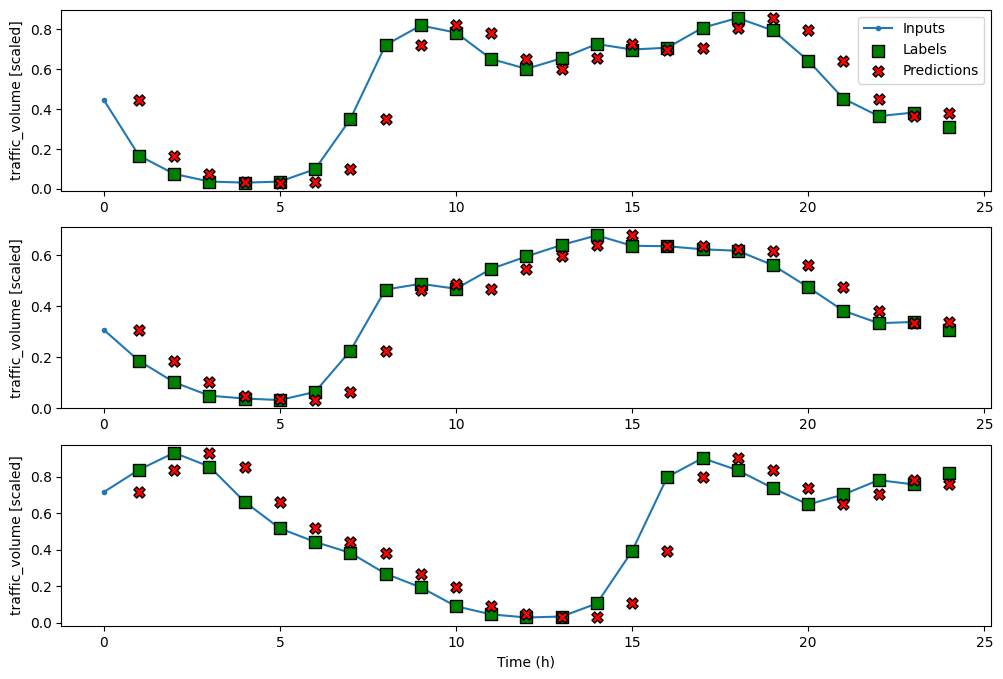

In [18]:
wide_window.plot(baseline_last)

*Predictions of our baseline single-step model on three sequences from the sample batch. The
prediction at each timestep is the last known value, meaning that our baseline works as expected*

In [20]:
# MAE of our baseline on the test set
mae_baseline = performance['Baseline - Last'][1]
print(f'MAE of baseline on the test set: {mae_baseline:.4}')

MAE of baseline on the test set: 0.08128


#### Multi-step baseline models

We’ll forecast the traffic volume for the next 24 hours of data given an input of 24 hours. Again, the first step is to generate the appropriate window of data. Because we wish to predict 24 timesteps into the future with an input of 24 hours, the `input_width` is 24, the `label_width` is 24, and the `shift` is also 24.

In [23]:
# We’ll forecast the traffic volume for the next 24 hours of data given an input of 24 hours
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

Baseline model: we’ll simply repeat the last known value over the next 24 timesteps.

#### Predicting the last known value

In [26]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1]) # If no target is specified, return the last known value of all cols over the next 24 tsteps
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1]) # Return the last known value of the target column over the next 24 timesteps

In [27]:
# Create an instance of the MultiStepLastBaseline model, specifying the label index for 'traffic_volume'
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

# Compile the model with Mean Squared Error (MSE) as the loss function and Mean Absolute Error (MAE) as the evaluation metric
ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

# Initialize dictionaries:
ms_val_performance = {}  # Dictionary to hold validation performance results
ms_performance = {}      # Dictionary to hold test performance results

# Evaluate the model on the validation dataset and store the results in the 'ms_val_performance' dictionary
ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val) 

# Evaluate the model on the test dataset and store the results in the 'ms_performance' dictionary
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)  

109/109 [==============================] - 0s 594us/step - loss: 0.1875 - mean_absolute_error: 0.3522


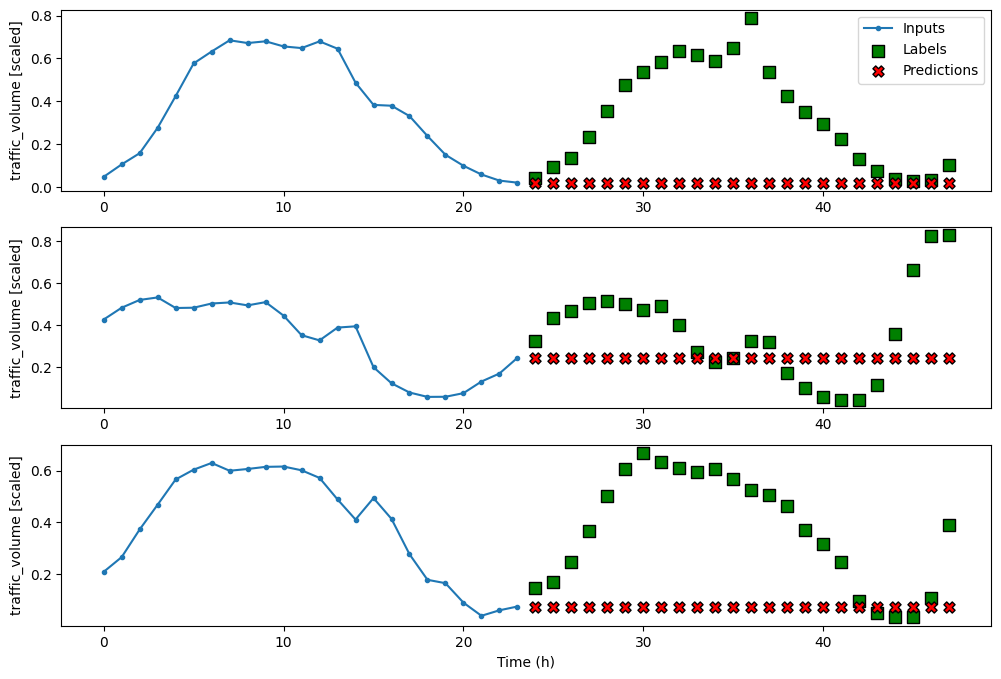

In [28]:
multi_window.plot(ms_baseline_last)

*Predicting the last known value for the next 24 timesteps. We can see that the predictions,
shown as crosses, correspond to the last value of the input sequence, so our baseline behaves as expected.*

In [30]:
# MAE of Baseline on the test set
mae_baseline = ms_performance['Baseline - Last'][1]
print(f'MAE of baseline on the test set: {mae_baseline:.4}')

MAE of baseline on the test set: 0.3473


#### Repeating the input sequence

In [32]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]  # Return the input sequence for the given target column

In [33]:
# Create an instance of the RepeatBaseline model, specifying the label index for 'traffic_volume'
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

# Compile the model with Mean Squared Error (MSE) as the loss function and Mean Absolute Error (MAE) as the evaluation metric
ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()]) 

# Evaluate the model on the validation dataset and store the results in the 'ms_val_performance' dictionary
ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val) 

# Evaluate the model on the test dataset and store the results in the 'ms_performance' dictionary
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0) 

109/109 [==============================] - 0s 549us/step - loss: 0.2065 - mean_absolute_error: 0.3473


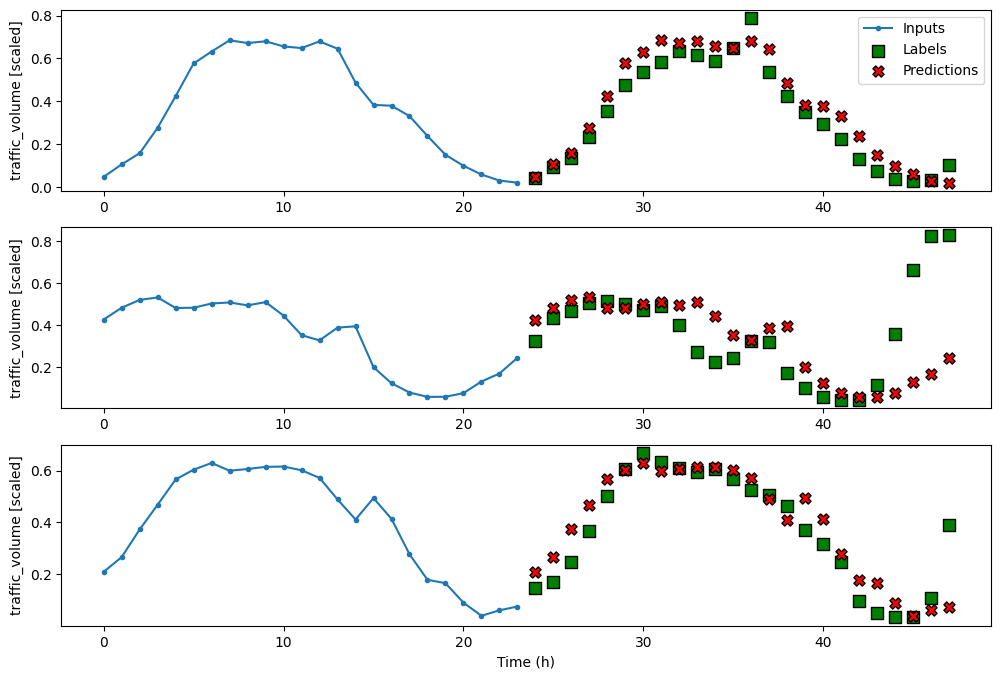

In [34]:
multi_window.plot(ms_baseline_repeat)

*Repeating the input sequence as the predictions. You’ll see that the predictions
(represented as crosses) match exactly the input sequence. You’ll also notice that many predictions
overlap the labels, which indicates that this baseline performs quite well.*

In [36]:
# MAE of Baseline on the test set
mae_baseline = ms_performance['Baseline - Last'][1]
print(f'MAE of baseline on the test set: {mae_baseline:.4}')

MAE of baseline on the test set: 0.3473


### Multi-output baseline model

In this situation, we wish to predict the traffic volume and the temperature for the next timestep using a single input data point. Essentially, we’re applying the single-step model on both the traffic volume and temperature, making it a multi-output model.

Again, we’ll start off by defining the window of data, but here we’ll define two windows: one for training and the other for visualization. Since the model takes in one data point and outputs one prediction, we want to initialize a wide window of data to visualize many predictions over many timesteps.

In [39]:
# Notice that we pass in both temp and traffic_volume, as those are our two targets for the multi-output model
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [40]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


In [41]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 [==============================] - 0s 603us/step - loss: 0.0069 - mean_absolute_error: 0.0482


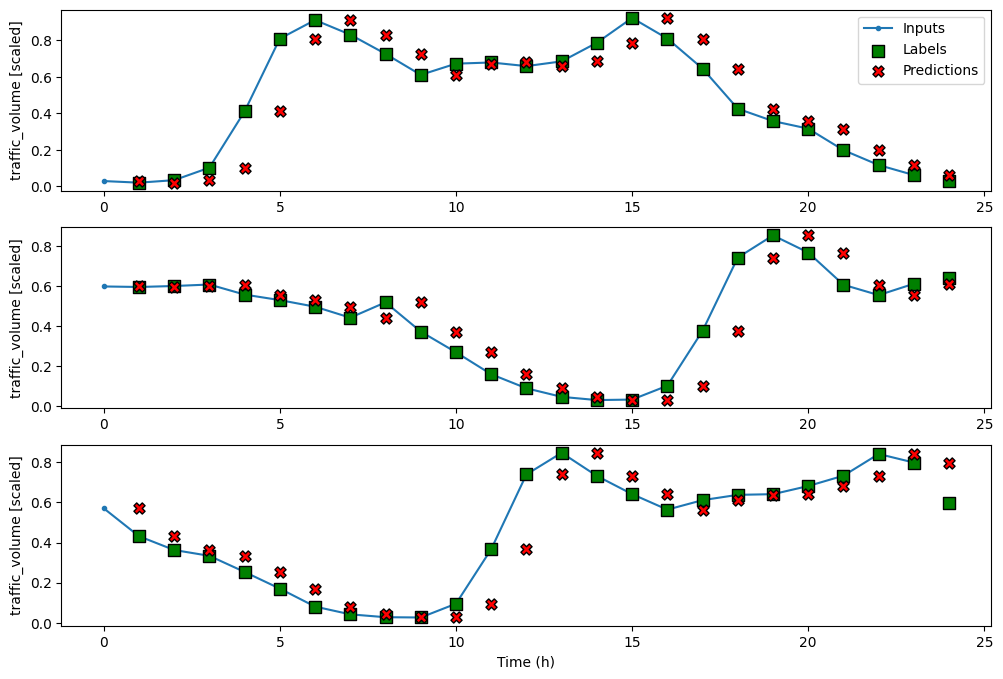

In [42]:
mo_wide_window.plot(mo_baseline_last)

*Predicting the last known value for traffic volume.*

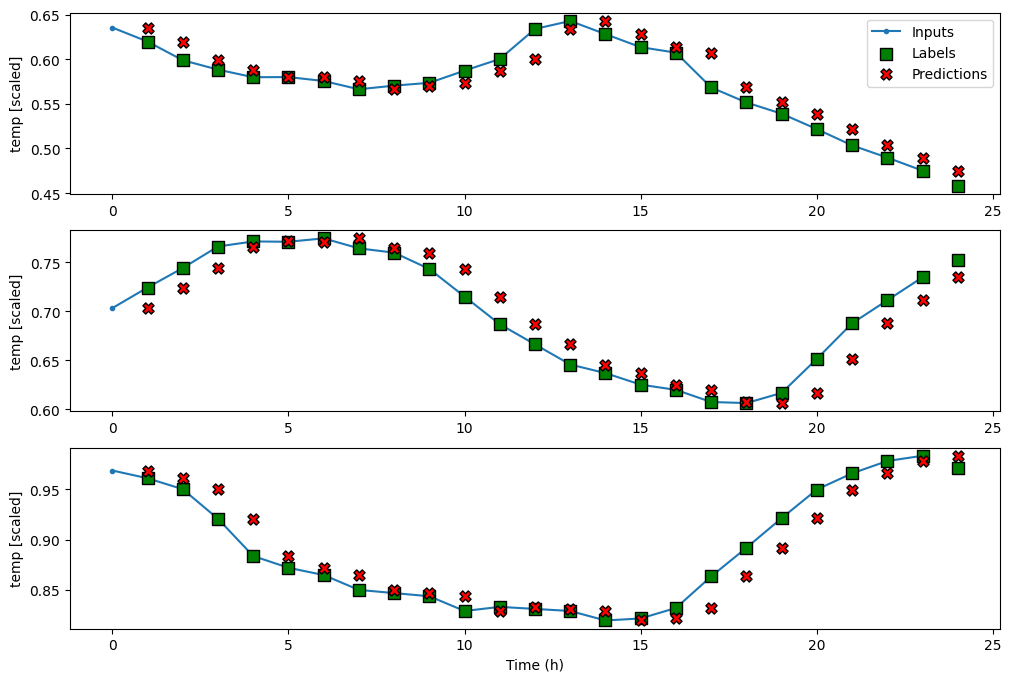

In [44]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

*Predicting the last known value for the temperature. The predictions (crosses) are equal to
the previous data point, so our baseline model behaves as expected.*

In [46]:
# MAE of Baseline on the test set
mae_baseline = mo_performance['Baseline - Last'][1]
print(f'MAE of baseline on the test set: {mae_baseline:.4}')

MAE of baseline on the test set: 0.04711


### Summary

    Data windowing is essential in deep learning to format the data as inputs and labels for the model.
    
    The DataWindow class can easily be used in any situation and can be extended to your liking. Make use of it in your own projects.
    
    Deep learning models require a loss function and an evaluation metric. In our case, we chose the mean squared error (MSE) as the loss function, because it penalizes large errors and tends to yield better-fit models. The evaluation metric is the mean absolute error (MAE), chosen for its ease of interpretation.